# 1. 데이터 로드 및 분포 확인

* 필요한 모듈 불러오기

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

* 데이터 불러오기

In [3]:
df = pd.read_csv('C:/Users/gram/OneDrive/바탕 화면/stock_project/stock_data.csv')
df.head()

,Unnamed: 0,open,high,low,close,volume
0,20220516,86900,87600,85700,85900,55383
1,20220513,84000,87400,83500,85800,86525
2,20220512,84700,85300,82700,83200,104007
3,20220511,87500,87500,85500,85800,108071
4,20220510,87500,88600,87000,88000,100350


In [4]:
# 컬럼 값 수정
df.rename({'Unnamed: 0':'date'}, axis = 1, inplace = True)

# date 컬럼의 데이터 타입 변환
df['date'] = df['date'].astype('str') # date 열 문자열로 변환
df['date'] = pd.to_datetime(df['date']) # datetime으로 변환

df

,date,open,high,low,close,volume
0,2022-05-16,86900,87600,85700,85900,55383
1,2022-05-13,84000,87400,83500,85800,86525
2,2022-05-12,84700,85300,82700,83200,104007
3,2022-05-11,87500,87500,85500,85800,108071
4,2022-05-10,87500,88600,87000,88000,100350
...,...,...,...,...,...,...
4465,2004-04-29,5117,5436,5025,5101,109911
4466,2004-04-28,5071,5452,4995,5444,182604
4467,2004-04-27,5452,5482,5033,5063,299489
4468,2004-04-26,5436,5741,5261,5398,343283


* 3일 이동평균선(3MA), 5일 이동평균선(5MA) 데이터 추가
 * 이동평균(Moving Average) : 일정 기간동안의 가격을 평균을 내어 수치화하고 이를 그래프로 그린 것
 * rolling() 메서드는 window size의 크기를 정하고 그 크기만큼 현재 위치를 기준으로 앞의 데이터 집합을 가지고 통계치를 구할 수 있음

In [5]:
# 기존 데이터가 날짜 내림차순으로 되어있으므로 오름차순으로 변경
df = df[::-1]

# 이동 평균선 생성 위해 rolling을 한 후 신규 객체에 column을 추가
ma3 = df['close'].rolling(window = 3).mean()
ma5 = df['close'].rolling(window = 5).mean()

df['ma3'] = ma3
df['ma5'] = ma5

df.head() # 8개의 column이 존재, 예측할 값은 close 값

C:\Users\gram\AppData\Local\Temp/ipykernel_18304/866447260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma3'] = ma3
C:\Users\gram\AppData\Local\Temp/ipykernel_18304/866447260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma5'] = ma5


,date,open,high,low,close,volume,ma3,ma5
4469,2004-04-23,6076,6799,5353,5353,1415109,NaN,NaN
4468,2004-04-26,5436,5741,5261,5398,343283,NaN,NaN
4467,2004-04-27,5452,5482,5033,5063,299489,5271.333333,NaN
4466,2004-04-28,5071,5452,4995,5444,182604,5301.666667,NaN
4465,2004-04-29,5117,5436,5025,5101,109911,5202.666667,5271.8


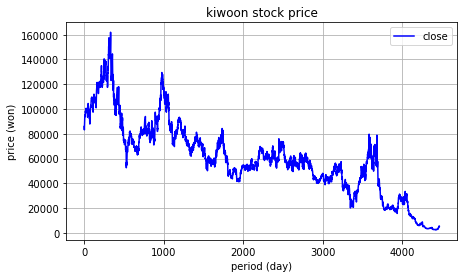

In [6]:
plt.figure(figsize = (7, 4))

plt.title('kiwoon stock price')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(df['close'], label = 'close', color = 'b')
plt.legend(loc = 'best')

plt.show()

# 2. 데이터 전처리
* outlier, missing value 확인 후 대체(또는 삭제) 처리
* 데이터 정규화 및 표준화
* 딥러닝 학습을 위한 feature column, label column 정의

* 통계 정보 확인

In [7]:
df.describe()

,open,high,low,close,volume,ma3,ma5
count,4470.000000,4470.000000,4470.000000,4470.000000,4.470000e+03,4468.000000,4466.000000
mean,59847.644072,60888.410738,58767.295749,59839.697315,1.023067e+05,59846.063638,59852.703045
std,30386.551561,30844.794825,29866.988782,30332.026463,1.159110e+05,30302.905332,30279.302981
min,2436.000000,2471.000000,2425.000000,2429.000000,2.811000e+03,2440.333333,2466.200000
25%,43162.500000,43700.000000,42462.500000,43100.000000,3.776100e+04,43170.166667,43090.600000
50%,58200.000000,59200.000000,57050.000000,58100.000000,6.531800e+04,58150.000000,58100.000000
75%,76100.000000,77500.000000,75000.000000,76175.000000,1.197088e+05,76050.000000,75855.000000
max,162500.000000,167500.000000,156000.000000,162000.000000,1.415109e+06,156833.333333,155100.000000


* 결측치 확인

In [8]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
ma3       2
ma5       4
dtype: int64

* 모든 Missing Value 삭제

In [9]:
df.dropna(inplace = True)

df.isnull().sum()

C:\Users\gram\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


date      0
open      0
high      0
low       0
close     0
volume    0
ma3       0
ma5       0
dtype: int64

* 정규화(Normalization)
 * 딥러닝 학습이 잘되기 위해서는 정규화 작업이 필요
 * 날짜를 나타내는 date 항목을 제외한 숫자로 표현되는 모든 column에 대해서 0~1 값으로 정규화 수행

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['open', 'high', 'low', 'close', 'volume', 'ma3', 'ma5'] # 정규화 대상 col 정의

scaled_df = scaler.fit_transform(df[scale_cols]) # 정규화 수행

print(type(scaled_df), '\n') # 리턴값은 넘파이

scaled_df = pd.DataFrame(scaled_df, columns = scale_cols)

print(scaled_df)

<class 'numpy.ndarray'> 

          open      high       low     close    volume       ma3       ma5
0     0.016750  0.017967  0.016930  0.016745  0.075880  0.017892  0.018381
1     0.015463  0.016536  0.016188  0.015792  0.073819  0.017645  0.017852
2     0.014607  0.015246  0.014703  0.014125  0.100434  0.016002  0.016915
3     0.014082  0.013864  0.013954  0.013643  0.065841  0.014934  0.016316
4     0.013463  0.013076  0.012964  0.012452  0.069642  0.013783  0.014969
...        ...       ...       ...       ...       ...       ...       ...
4461  0.531437  0.521902  0.550708  0.536257  0.069106  0.563668  0.579779
4462  0.531437  0.515237  0.540941  0.522470  0.074576  0.551577  0.569951
4463  0.513944  0.501906  0.522709  0.506176  0.071697  0.539055  0.556979
4464  0.509571  0.514631  0.527918  0.522470  0.059311  0.534305  0.549641
4465  0.527689  0.515843  0.542243  0.523096  0.037247  0.534521  0.545579

[4466 rows x 7 columns]


* feature column / label column 정의
 * 딥러닝 학습을 위한 입력 데이터 feature column, 타겟데이터 label column 정의 후 numpy로 변환하여 데이터 전처리 과정을 완료함

In [11]:
feature_cols = ['ma3', 'ma5', 'close']
label_cols = ['close']

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

# 딥러닝 학습을 위해 df -> np로 변환
label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

# 3. 데이터 생성
 * Window size 설정 후 feature / label 시계열 데이터 생성
   * window size : 몇 개의 데이터를 이용해 target 데이터를 예측할 것인지 결정
 * 학습 데이터 생성. 이 때 입력되는 데이터는 (batch size, time steps, input dims) 형태의 3차원 텐서로 생성되어야 함.
   * batch size : window size로 인해 분리된 데이터가 총 몇 개인지 나타냄
   * time steps : 몇 개의 데이터를 이용해 target 데이터를 예측할 것인지 결정
   * input dims : rnn layer로 한 번에 들어가는 데이터가 몇 개인지 나타냄

* 학습 데이터 X, Y 생성

In [12]:
def make_sequence_dataset(feature, label, window_size):
    feature_list = [] # 생성될 피처 리스트
    label_list = [] # 생성될 라벨 리스트
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list) # 3차원 텐서로 리턴헤줌

window_size = 40 # 앞의 40개의 데이터를 이용해 예측

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(4426, 40, 3) (4426, 1)


* train / test 데이터셋 분리

In [13]:
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

# 4. 순환신경망 모델 구축 및 학습

* LSTM 모델 구축

In [14]:
model = Sequential()

model.add(LSTM(128,
               activation = 'tanh', # layer에 tanh를 활성화 함수로 가지는 노드 수 128개
               input_shape = x_train[0].shape))

model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


* 모델 컴파일 및 학습

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

# 조기 중단을 위한 설정
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 16, callbacks = [early_stop])

Epoch 1/100
265/265 [==============================] - 14s 38ms/step - loss: 0.0014 - mae: 0.0201 - val_loss: 4.1063e-04 - val_mae: 0.0163
Epoch 2/100
265/265 [==============================] - 8s 30ms/step - loss: 3.9381e-04 - mae: 0.0138 - val_loss: 3.9170e-04 - val_mae: 0.0151
Epoch 3/100
265/265 [==============================] - 8s 29ms/step - loss: 3.5954e-04 - mae: 0.0134 - val_loss: 3.0082e-04 - val_mae: 0.0136
Epoch 4/100
265/265 [==============================] - 8s 30ms/step - loss: 3.0976e-04 - mae: 0.0124 - val_loss: 2.6624e-04 - val_mae: 0.0128
Epoch 5/100
265/265 [==============================] - 8s 31ms/step - loss: 2.6504e-04 - mae: 0.0112 - val_loss: 4.2879e-04 - val_mae: 0.0174
Epoch 6/100
265/265 [==============================] - 9s 32ms/step - loss: 2.5307e-04 - mae: 0.0111 - val_loss: 3.6205e-04 - val_mae: 0.0154
Epoch 7/100
265/265 [==============================] - 9s 35ms/step - loss: 2.4022e-04 - mae: 0.0108 - val_loss: 2.7787e-04 - val_mae: 0.0136
Epoch 8/1

=> 100번의 실행 중 20번째부터 loss 값이 더 이상 작아지지 않아 조기 중단되는 것을 확인할 수 있음

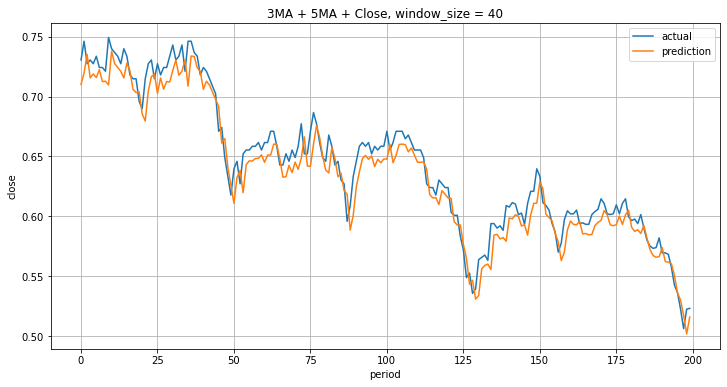

In [16]:
pred = model.predict(x_test)

plt.figure(figsize = (12, 6))
plt.title('3MA + 5MA + Close, window_size = 40')
plt.ylabel('close')
plt.xlabel('period')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')
plt.show()